# Disney

### Datasets
Disney+ Hotstar Catalod

### Columns
6244 Instances over columns: 
- ID
- Title
- Description
- Genre
- Year
- Age Rating (U, A, U/A 7+, U/A 13+, U/A 16+)
- Running Time (if type = 'movie')
- Seasons (if type = 'tv')
- Episodes (if type = 'tv')
- Type (movie/tv)

### Methods
- Basic Visualization
- NLP: 
    - Tokenizine, Text Preparation
    - TF-IDF
    - Multinomial Naive Bayes


### Retrieval
The following dataset was downloaded from kaggle [here](https://www.kaggle.com/datasets/goelyash/disney-hotstar-tv-and-movie-catalog)






In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
import math
# NLP:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
# ---------------------------
ds = pd.read_csv('hotstar.csv')
best_tokenizer = RegexpTokenizer(r'\w+')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shahafdan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Dataset Preparations

In [92]:
ds['description'] = [best_tokenizer.tokenize(x.lower()) for x in ds['description']]
ds['description'] = ds['description'].apply(lambda x: [w for w in x if not w in stop_words])
ds['description'] = [' '.join(x) for x in ds['description']]

## Basic Analysis

#### Average of Episodes / Seasons released each year.

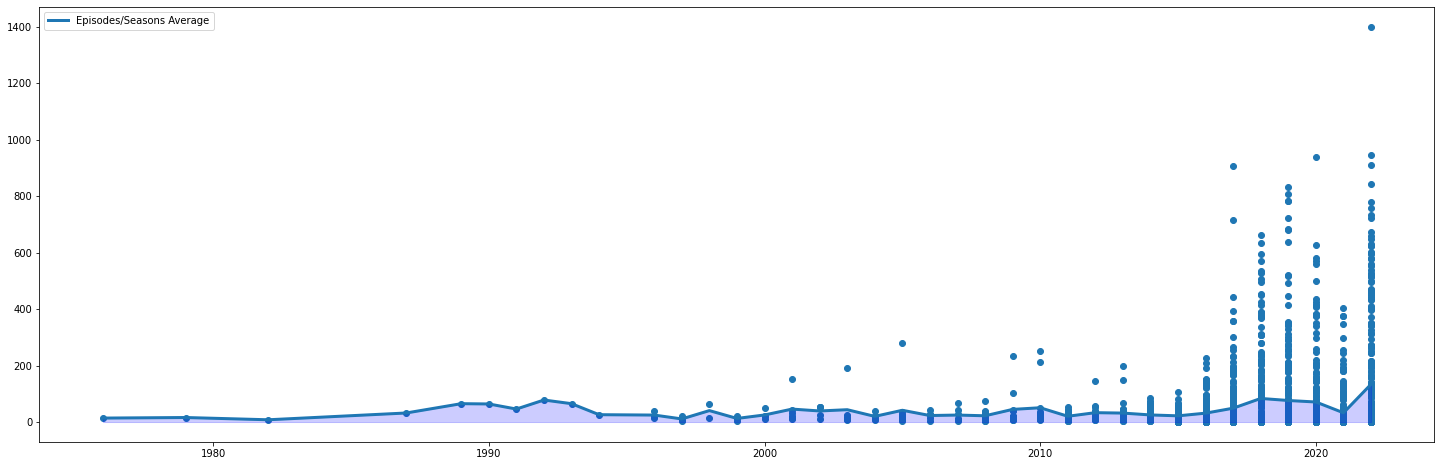

In [2]:
plt.figure(figsize = (25, 8))

ds['type'].value_counts()
tvs = ds[ds['type'] == 'tv']
tvs = tvs[['hotstar_id', 'year', 'episodes', 'seasons']]
tvs['eps'] = round(tvs['episodes'] / tvs['seasons'], 0)
tvs.sort_values(by='year')
eps_avg = tvs.groupby(['year'], as_index = False)['eps'].mean()
plt.scatter(tvs['year'], tvs['eps'])
plt.plot(eps_avg['year'], eps_avg['eps'], linewidth = 3, label = 'Episodes/Seasons Average')
plt.fill_between(x = eps_avg['year'], y1= eps_avg['eps'], color= "b", alpha= 0.2)
plt.legend(loc="upper left")
plt.show()

#### Genres Plotter
Each point represents the release of a movie (colored by genre) in a specific year.

The lines represent the number of movies (per genre) released each year


* Only 4 top genres are used: Drana, Action, Thriller, Romance

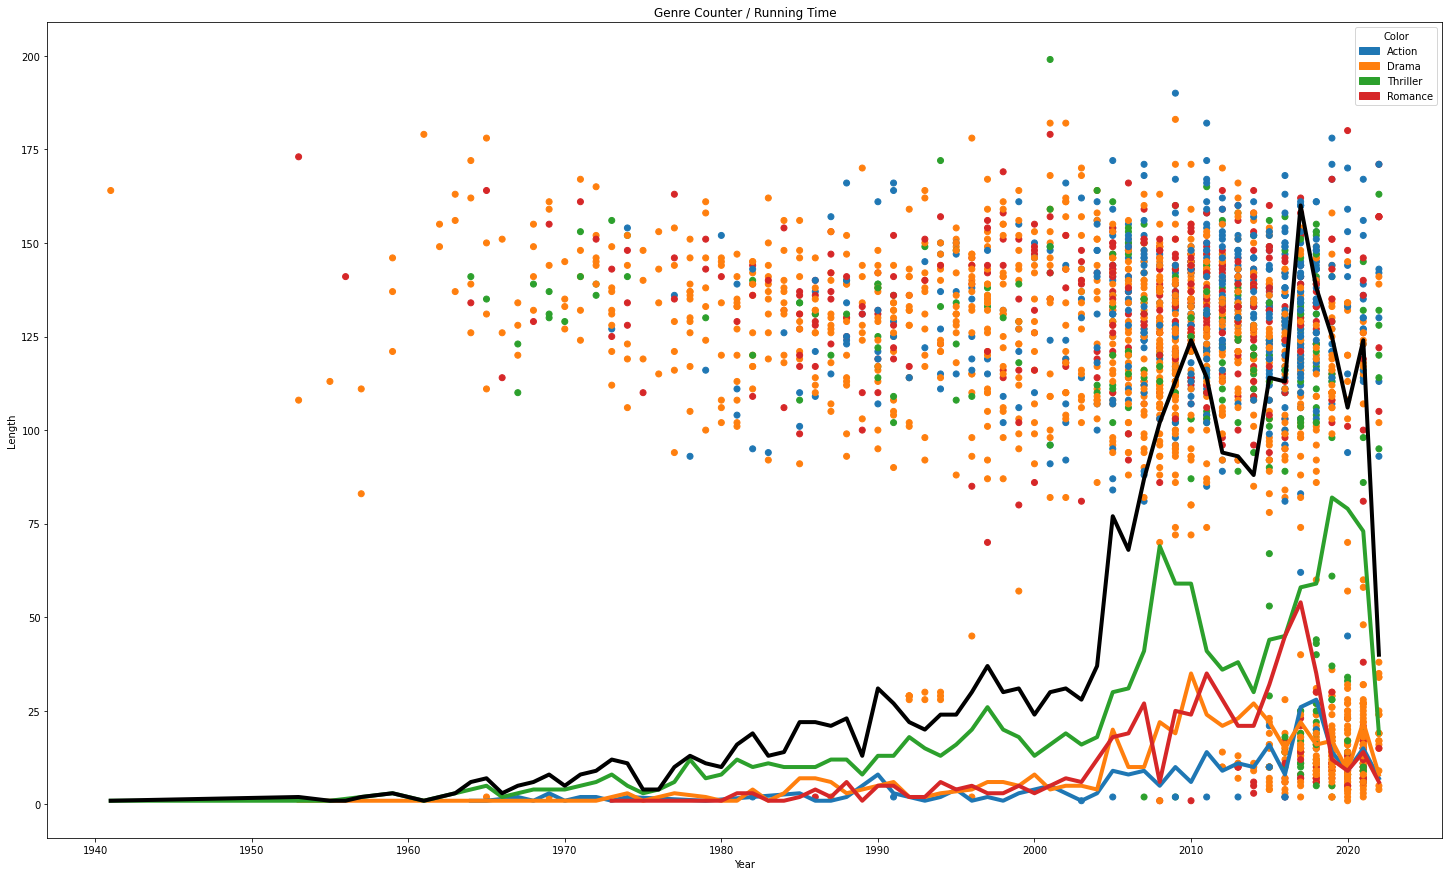

In [3]:
plt.figure(figsize = (25, 15))

movies = ds[ds['type'] == 'movie']
movies = movies[['genre', 'running_time', 'year', 'age_rating']]
movies = movies[movies['genre'].isin(['Drama', 'Action', 'Thriller', 'Romance'])]

def adjust_ratings(x):
    if(x == 'A'): return 'A'
    elif(x == 'U'): return 'U'
    elif(x == 'U/A 16+'): return '16'
    elif(x == 'U/A 13+'): return '13'
    elif(x == 'U/A 7+'): return '7'

movies['age_rating'] = list(map(lambda x: adjust_ratings(x), movies['age_rating']))

levels, categories = pd.factorize(movies['genre'])
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]

plt.scatter(movies['year'], movies['running_time'], c = colors)
year_count = movies['year'].value_counts().sort_index()
for i in list(set(movies['genre'])):
    plt.plot(movies[movies['genre'] == i]['year'].value_counts().sort_index(), linewidth = 4)
plt.plot(year_count, linewidth = 4, color='black', label = "Total")
plt.gca().set(xlabel='Year', ylabel='Length', title='Genre Counter / Running Time')
plt.legend(handles=handles, title='Color')

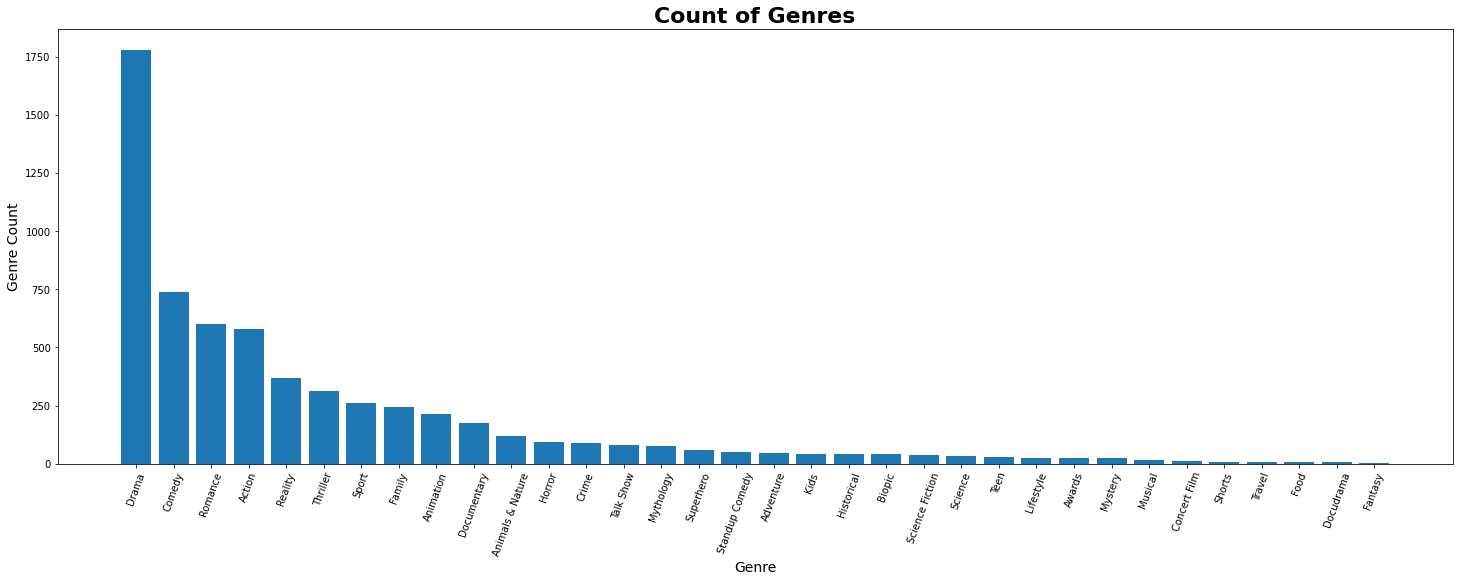

In [70]:
value_count = ds['genre'].value_counts()
value_count_indxs = value_count.index
plt.figure(figsize = (25, 8))
plt.bar(value_count_indxs, value_count)
plt.xticks(rotation = 70)
plt.xlabel('Genre', fontsize = 14)
plt.ylabel('Genre Count', fontsize = 14)
plt.title('Count of Genres', fontsize = 22, fontweight = 'bold')
plt.show()

## Review NLP

#### Genre Prediction Based on Description (TF-IDF)
Only use top 6 genres in value counts, to avoid outlier impact on model
- Drama
- Comedy
- Romance
- Action
- Reality
- Thriller

Two Classification Algorithms:
- K Nearest Neighbors
- Multinomial Naive Bayes

In [104]:
ds_ = ds[(ds['type'] == 'movie') & (ds['genre'].isin(['Drama', 'Comedy', 'Romance', 'Action', 'Reality', 'Thriller']))][['title', 'description', 'genre', 'running_time', 'year']]
# train and test TF-IDF model:
X_train, X_test, y_train, y_test = train_test_split(ds_['description'], ds_['genre'], test_size = 0.2, random_state = 42)
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)

naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, y_train)
predictions = naive_bayes_classifier.predict(X_test_tf)

#### Results:
Accuracy Score is only 0.48%. Therefore, maybe classifying the genre based on 